In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from karateclub.graph_embedding import Graph2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split, learning_curve
from sklearn.metrics import *

from master_thesis.utils.plotting import *
from master_thesis.utils import *

In [3]:
SEED = 39
N_ROIS = 100
CAUSAL_COEFF_STRENGTH = 1.7
EMBEDDING_HIDDEN_DIM = 16

In [4]:
networks_dir = "../../Datasets/NeuroFlicks/networks/"
# List of all networks
np_files = os.listdir(networks_dir)

# Get labels from file names
labels = np.array([np_file[4:7] == 'PAT' for np_file in np_files])

# Load all networks, and calculate mean score and std
np_matrices = np.array([np.load(os.path.join(networks_dir, np_file))[1] for np_file in np_files])
score_mean, score_std = np.array(np_matrices).mean(), np.array(np_matrices).std()

# Binarize networks
np_networks = np_matrices > score_mean + CAUSAL_COEFF_STRENGTH * score_std

# Split networks into iter- and intra-hemispheric
n_rois_hemisphere = N_ROIS // 2
np_networks_left2left = np_networks[:, :n_rois_hemisphere, :n_rois_hemisphere]
np_networks_left2right = np_networks[:, :n_rois_hemisphere, n_rois_hemisphere:]
np_networks_right2left = np_networks[:, n_rois_hemisphere:, :n_rois_hemisphere]
np_networks_right2right = np_networks[:, n_rois_hemisphere:, n_rois_hemisphere:]

# Convert to networkx graphs
dataset_full = [nx.from_numpy_array(np_network, create_using=nx.DiGraph) for np_network in np_networks]
dataset_left2left = [nx.from_numpy_array(np_network, create_using=nx.DiGraph) for np_network in np_networks_left2left]
dataset_left2right = [nx.from_numpy_array(np_network, create_using=nx.DiGraph) for np_network in np_networks_left2right]
dataset_right2left = [nx.from_numpy_array(np_network, create_using=nx.DiGraph) for np_network in np_networks_right2left]
dataset_right2right = [nx.from_numpy_array(np_network, create_using=nx.DiGraph) for np_network in np_networks_right2right]

# Balance of control and patological samples
n_control = len(labels) - labels.sum()
n_patological = labels.sum()

# Print dataset info
print(f"No of control samples: {n_control}")
print(f"No of patological samples: {n_patological}")

No of control samples: 69
No of patological samples: 382


In [15]:
image_control = np.mean(np_matrices[labels == 0], axis=0)
image_pathological = np.mean(np_matrices[labels == 1], axis=0)

In [16]:
# Set diagonal to ones
np.fill_diagonal(image_control, 0.5)
np.fill_diagonal(image_pathological, 0.5)

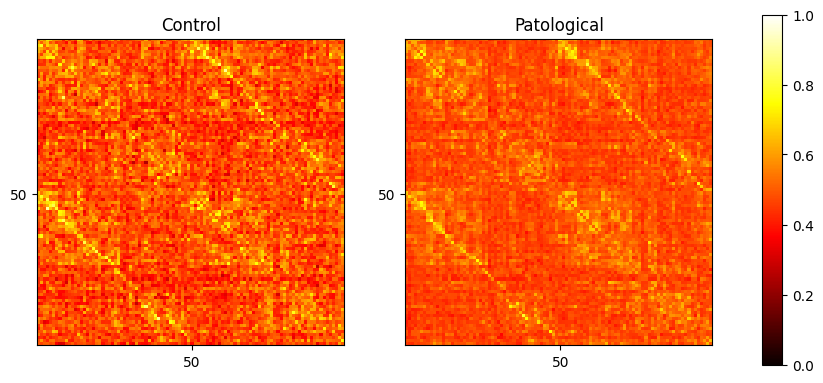

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_control, cmap='hot', vmin=0, vmax=1)
axes[0].set_title("Control")
axes[1].imshow(image_pathological, cmap='hot', vmin=0, vmax=1)
axes[1].set_title("Patological")

axes[0].set_xticks([50])
axes[0].set_yticks([50])
axes[1].set_xticks([50])
axes[1].set_yticks([50])

# Add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(axes[0].imshow(image_control, cmap='hot', vmin=0, vmax=1), cax=cbar_ax)

plt.savefig("/Users/wciezobka/Downloads/ec-networks.png", dpi=300, bbox_inches='tight')

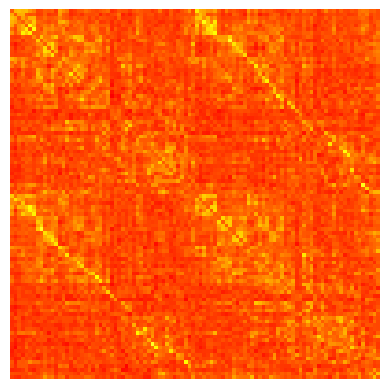

In [26]:
plt.imshow(image_pathological, cmap='hot', vmin=0, vmax=1)
plt.axis('off')
# plt.colorbar()
plt.savefig("/Users/wciezobka/Downloads/ec-networks.svg", dpi=300, bbox_inches='tight')

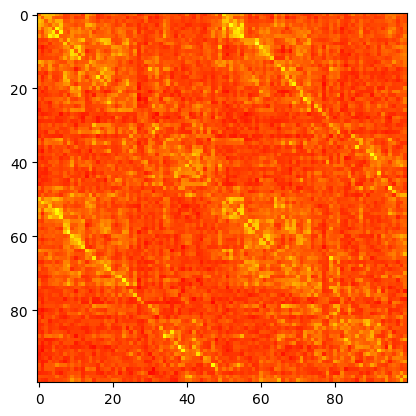

In [41]:
plt.imshow(image_pathological, cmap='hot', vmin=0, vmax=1)

In [47]:
# Get indeces of true labels
idx_pat = np.where(labels == True)[0]
idx_con = np.where(labels == False)[0]

In [91]:
model_left2left = Graph2Vec(dimensions=(EMBEDDING_HIDDEN_DIM // 4), wl_iterations=2, epochs=200, seed=SEED, workers=1)
model_left2right = Graph2Vec(dimensions=(EMBEDDING_HIDDEN_DIM // 4), wl_iterations=2, epochs=200, seed=SEED, workers=1)
model_right2left = Graph2Vec(dimensions=(EMBEDDING_HIDDEN_DIM // 4), wl_iterations=2, epochs=200, seed=SEED, workers=1)
model_right2right = Graph2Vec(dimensions=(EMBEDDING_HIDDEN_DIM // 4), wl_iterations=2, epochs=200, seed=SEED, workers=1)

model_left2left.fit(dataset_left2left)
model_left2right.fit(dataset_left2right)
model_right2left.fit(dataset_right2left)
model_right2right.fit(dataset_right2right)

embedding_left2left = model_left2left.get_embedding()
embedding_left2right = model_left2right.get_embedding()
embedding_right2left = model_right2left.get_embedding()
embedding_right2right = model_right2right.get_embedding()

In [92]:
embeddings = np.concatenate((embedding_left2left, embedding_left2right, embedding_right2left, embedding_right2right), axis=1)
embeddings.shape

(451, 16)

In [93]:
X_train, y_train, X_test, y_test = balance_split_dataset(embeddings, labels, half_test_size=20, verbose=True)

X_train shape: (724, 16), y_train shape: (724,)
X_test shape: (40, 16), y_test shape: (40,)
Ratio of positive samples in train: 0.5
Ratio of positive samples in test: 0.5


Best params: {'alpha': 0.5623413251903491}
Best score: 0.6472928996619591
Train accuracy: 0.60,		Test accuracy: 0.60
Train recall: 0.63, Test recall: 0.55
Train precision: 0.60, Test precision: 0.48
Train f1: 0.61, Test f1: 0.51
Train AUC: 0.60, Test AUC: 0.48


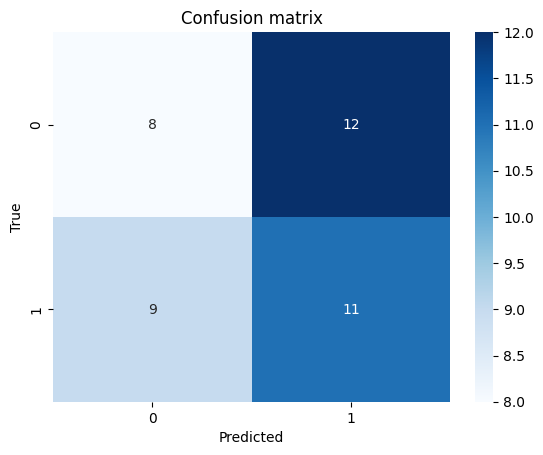

In [94]:
params = {'alpha': np.logspace(-1, 3, 17)}

clf = GridSearchCV(RidgeClassifier(), params, cv=5, scoring='f1', n_jobs=-1)
clf.fit(X_train, y_train)

print(f"Best params: {clf.best_params_}")
print(f"Best score: {clf.best_score_}")

# Fit Ridge classifier
rc = RidgeClassifier(alpha=100.)
rc.fit(X_train, y_train)
y_train_hat, y_test_hat = rc.predict(X_train), rc.predict(X_test)

# Evaluate
evaluate(y_train, y_train_hat, y_test, y_test_hat)

Train accuracy: 0.67,		Test accuracy: 0.67
Train recall: 0.70, Test recall: 0.50
Train precision: 0.67, Test precision: 0.43
Train f1: 0.68, Test f1: 0.47
Train AUC: 0.67, Test AUC: 0.42


/Users/wciezobka/venvs/sano/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


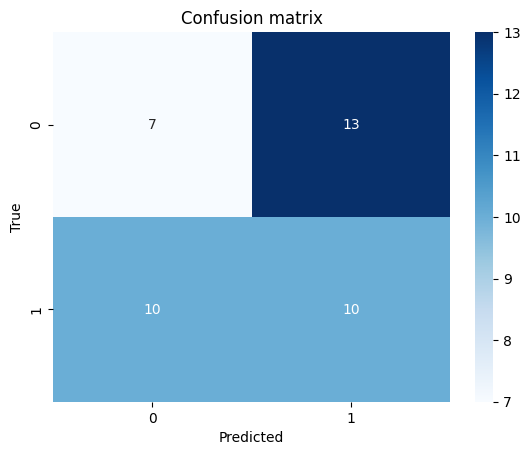

In [102]:
# Fit Ridge classifier
mlp = MLPClassifier(hidden_layer_sizes=(64), max_iter=10)
mlp.fit(X_train, y_train)
y_train_hat, y_test_hat = mlp.predict(X_train), mlp.predict(X_test)

# Evaluate
evaluate(y_train, y_train_hat, y_test, y_test_hat)

# Conclusions
The method of splitting the networks into inter and intra-hemispheric does not improve the results. Actually the results are worse.
If I set the emmbeding dimensions to sum up to the previous value, we lose to much information and the results are worse. If the embedding dimensions are kept per left2left etc. the resulting space is to big, and the results are not good either.  
  
### Possible solutions
- Try to use mlp per left2left etc. and then aggregate the results in some clever way. This solution needs the information of the lesion side
- ...